In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import chi2_contingency
import scipy.stats as stats

# classification model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

In [3]:
df = pd.read_excel(r'./../data/creditcardmarketing.xlsx') 
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [4]:
categoricals = df.select_dtypes(object)
categoricals.head()

,Offer Accepted,Reward,Mailer Type,Income Level,Overdraft Protection,Credit Rating,Own Your Home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


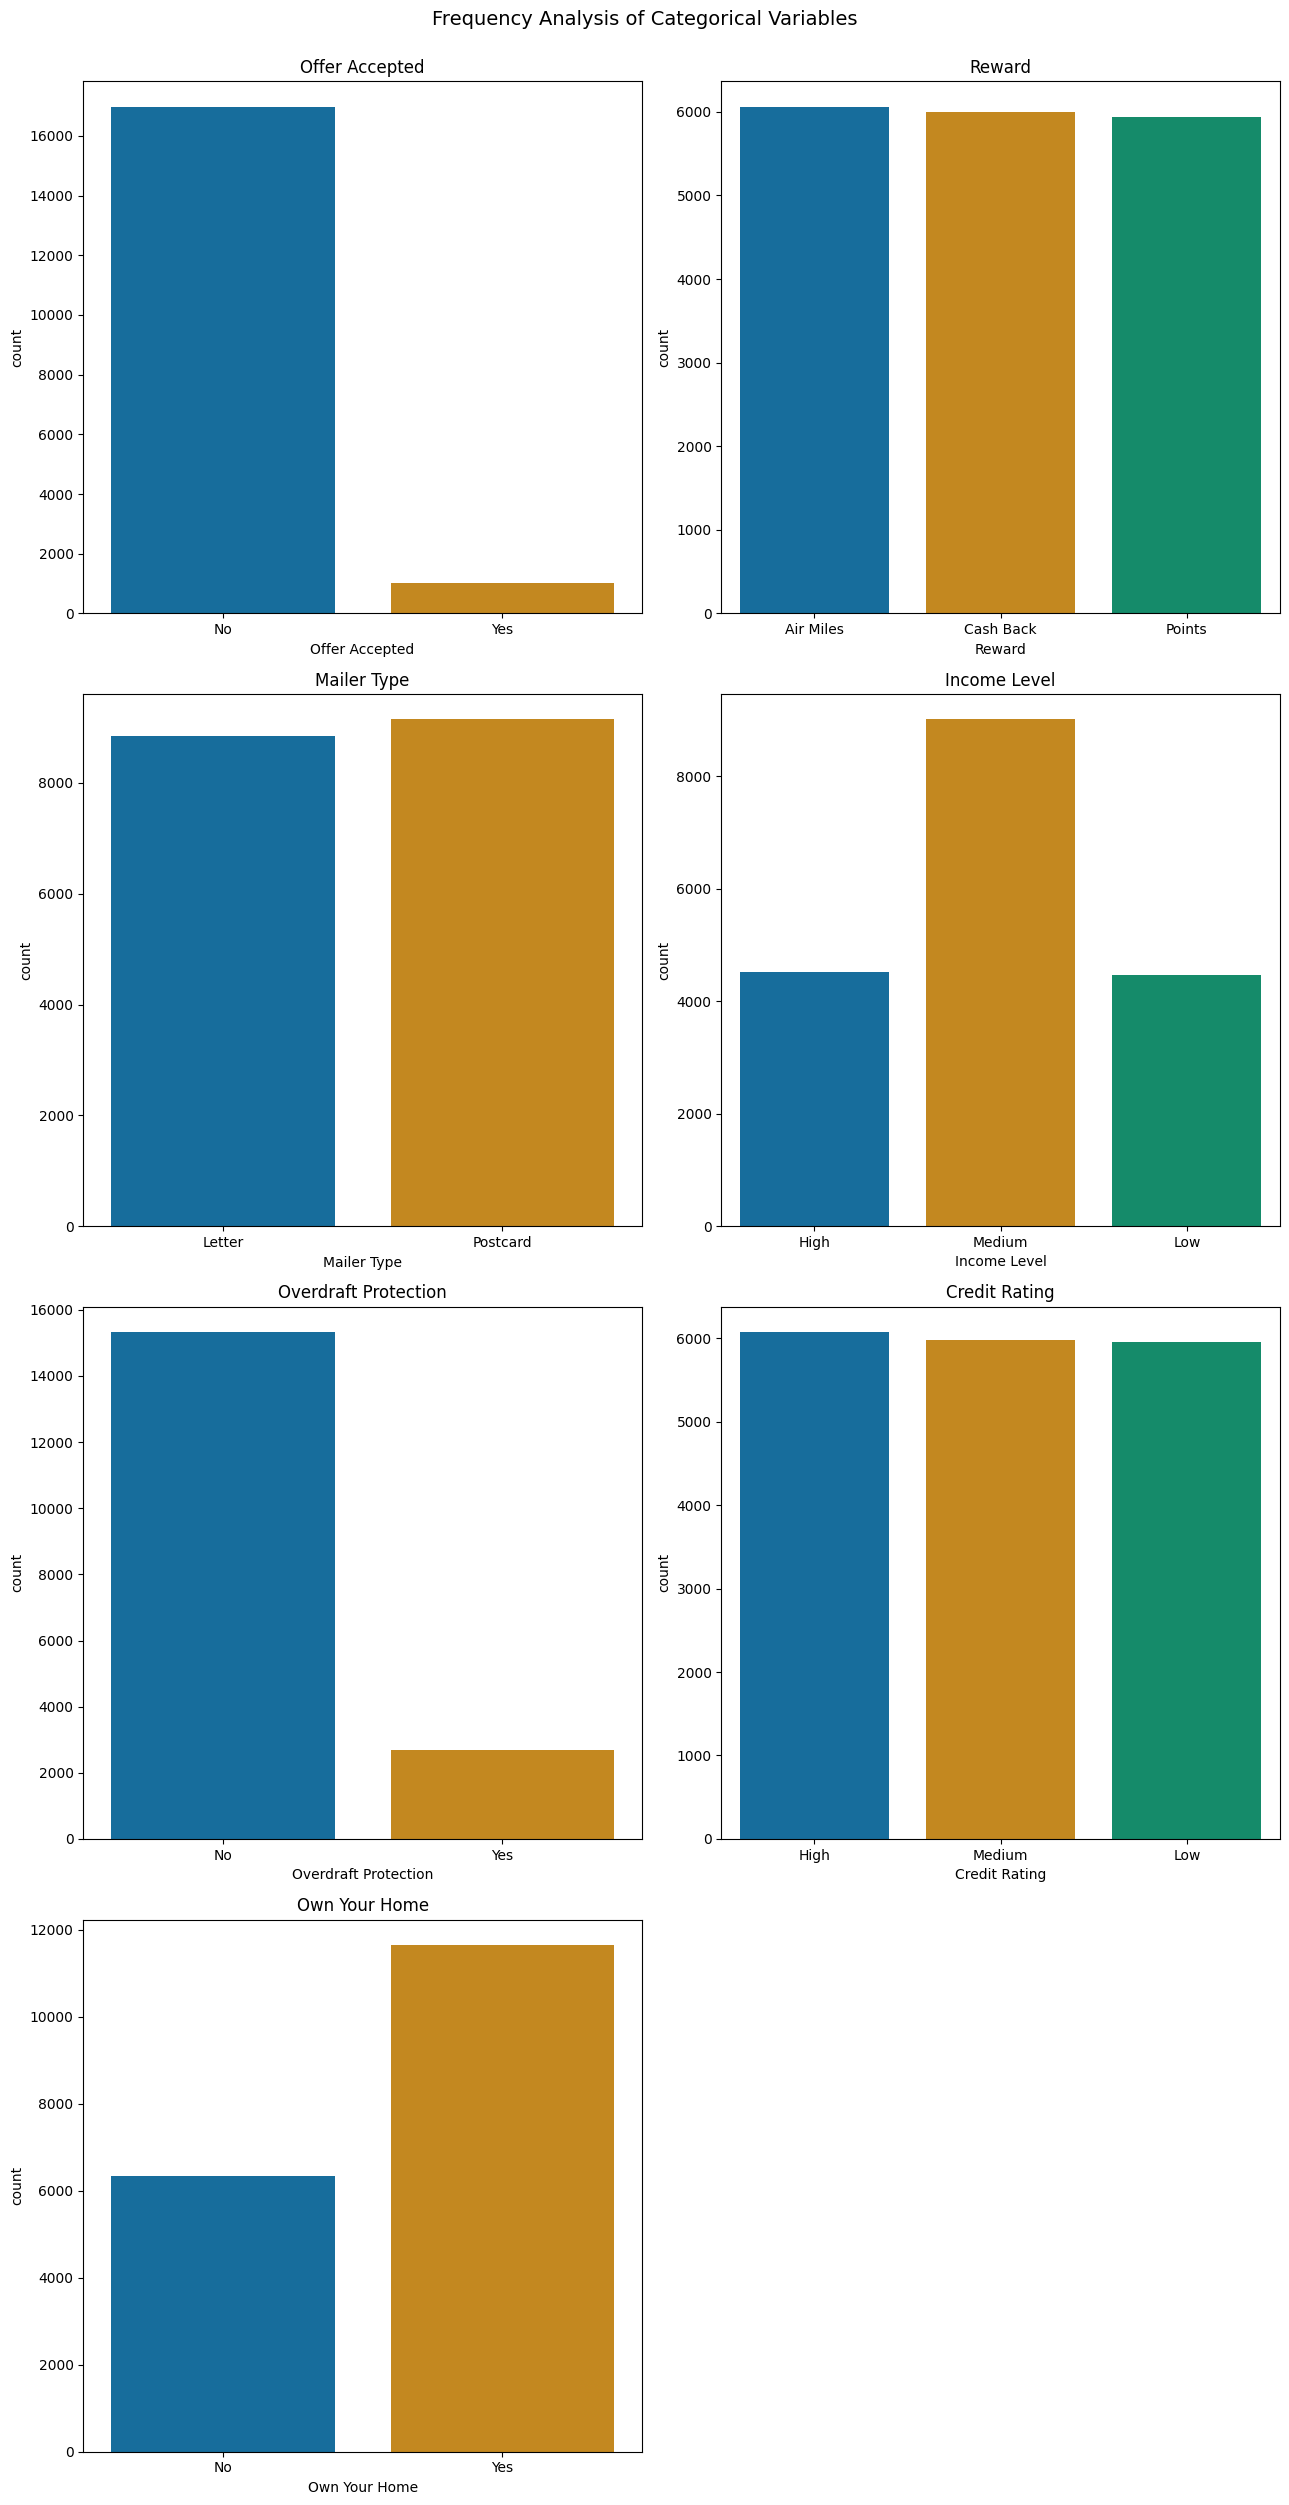

In [5]:
a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (13,25))
plt.suptitle("Frequency Analysis of Categorical Variables", fontsize = 14, y=1)
sns.set_palette('colorblind')

for i in categoricals:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.countplot(data = categoricals, x = i)
    c = c + 1

plt.tight_layout()
plt.show()

In [9]:
homes = df[['# Homes Owned', 'Own Your Home']]
homes.columns = ['homes_owned', 'own_your_home']
homes.head()

,homes_owned,own_your_home
0,1,No
1,2,Yes
2,1,Yes
3,1,No
4,1,Yes


In [ ]:
X = df = pd.read_csv(r'./../data/X.csv')
X.head()

,Unnamed: 0,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,...,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,...,2,1,0,0,1,0,1,0,1,0
1,1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,...,1,1,0,0,1,0,1,0,0,1
2,2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,...,1,1,0,0,0,1,1,0,0,1
3,3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,...,2,1,0,0,1,0,1,0,1,0
4,4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,...,1,1,0,0,1,0,1,0,0,1


In [ ]:
y = df = pd.read_csv(r'./../data/y.csv')
y.head()

,Unnamed: 0,offer_accepted
0,0,No
1,1,No
2,2,No
3,3,No
4,4,No


In [ ]:
X.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
y.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [ ]:
y.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No
